# ✨ MOST SUCCESSFUL MODEL ✨<br>
# V3 version <br>
## compare to V2: <br>
  &nbsp; * &nbsp; Added random_normal weight initializer <br>
  &nbsp; * &nbsp; Param change:
    # New LR_GEN, LR_DISC to manage their learning rate
    # New BETA_GEN, BETA_DISC
    # INIT_STDDEV for weight initializer
    # ALTERNATOR 3 -> 2 *note
    # LATENT_DIM 20 -> 40
    # EPOCH 1000 -> 300 *note
  &nbsp; * &nbsp; Moved the activition function after batchnorm in both models<br>
  note:
    # I ran the training function multiple times with the same model and manually changed some variables 
    # after both model stablized, with the first run with 1000 epoch and alternator = 3, this resulted in loss_gen ~ 0.7 
    # and loss_disc ~ 1.2. Then following run with 300 epochs and alternator = 2, 
    # this resulted in loss_gen ~ 1.4 and loss_disc ~ 1 and further stablized the model.
    # The model is trained with ~2000 epochs total and show better details and variation vs model V2.  

  

In [ ]:
## Imports
# tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import RandomNormal

# others
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from glob import glob
import os
import time
import math

In [ ]:
## variables
IMG_SIZE = (64,64,3)
EPOCH = 300
LATENT_DIM = 40
BATCH_SIZE = 128
EPOCH_SIZE = 50000 # how many imgs in each epoch 
SEED_SIZE = 16 # how many pictures to track progress of (must be perfect square for sample_image())
ALTERNATOR = 2 # times generator gets trained | each time discriminator gets trained
LR_GEN, LR_DISC = 0.0001, 0.00025
BETA_GEN, BETA_DISC = 0.5, 0.5
INIT_STDDEV = 0.02

# path 
img_path = "./DCGAN"
data_path = "./data.npy"
output_img_dir="/content/drive/MyDrive/DCGAN_img"
model_output_path="/content/drive/MyDrive/saved_models/v3_gen_2"

In [ ]:
# global variable: IMG_SIZE
def process_images(in_path, out_path):
  input_dir_error = not os.path.isdir(in_path)
  output_file_exist = os.path.isfile(out_path)

  if output_file_exist:
    print("Output file already exists, loading...")
    dataset = np.load(out_path)
  elif input_dir_error:
    print("Error: input path error")
    return None

  else:  
    image_files = glob(in_path + '/*.jpg')
    # main loop
    i = 0
    dataset = []
    for img in image_files:
      new_img = image.load_img(img)
      new_img = np.asarray(new_img)
      new_img = tf.image.resize(new_img, [IMG_SIZE[0],IMG_SIZE[1]])
      dataset.append(new_img)
      # track progress
      i += 1
      if i%100 == 0:
        print("Pictures processed: ", i)
    # scale and save
    dataset = np.array(dataset)
    dataset = dataset / 255 * 2 - 1
    np.save(out_path, dataset)
    print(f'Coverted {len(image_files)} images')

  print("data preparation finish")
  return dataset

In [ ]:
# Save image for progress tracking
# global variable: output_img_dir, SEED_SIZE
def sample_images(epoch, seeds):
  generated_image = generator(seeds, training=False)
  generated_image = generated_image / 2 + 0.5


  edge_size = int(math.sqrt(SEED_SIZE))
  fig, axs = plt.subplots(edge_size, edge_size)
  idx = 0
  for i in range(edge_size):
    for j in range(edge_size):
      axs[i,j].imshow(generated_image[idx])
      axs[i,j].axis('off')
      idx += 1
  fig.savefig(f"{output_img_dir}/{epoch}.jpg")
  plt.close()

  print(f"{output_img_dir}/{epoch}.jpg saved")

In [ ]:
# process_images and load data
prepared_data = process_images(img_path, data_path) # used for creating training/testing set
data_shape = prepared_data.shape
print(f'shape of the data is {data_shape}')

data_train = tf.data.Dataset.from_tensor_slices(prepared_data).shuffle(EPOCH_SIZE).batch(BATCH_SIZE)
del prepared_data

Output file already exists, loading...
data preparation finish
shape of the data is (5000, 64, 64, 3)


In [ ]:
# global variable: LATENT_DIM, IMG_SIZE
def create_generator():
  i = layers.Input(shape=(LATENT_DIM,))
  x = layers.Dense(4*4*512, use_bias=False, kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(i)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Reshape((4, 4, 512))(x)
  # -> 4, 4, 512
  x = layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(x)
  x = layers.BatchNormalization(momentum=0.6)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.2)(x)
  # -> 8, 8, 256
  x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(x)
  x = layers.BatchNormalization(momentum=0.6)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.2)(x)
  # -> 16, 16, 128
  x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(x)
  x = layers.BatchNormalization(momentum = 0.6)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.2)(x)
  # -> 32, 32, 64
  x = layers.Conv2DTranspose(IMG_SIZE[2], kernel_size=3, strides=2, padding='same', use_bias=False, activation='tanh', kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(x)
  # 64, 64, 3, matching IMG_SIZE

  model = Model(i, x)
  return model
  

In [ ]:
# global variable: IMG_SIZE
def create_discriminator():
  i = layers.Input(shape=IMG_SIZE)

  x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(i)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(x)
  x = layers.BatchNormalization(momentum = 0.6)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(256, kernel_size=5, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(x)
  x = layers.BatchNormalization(momentum = 0.6)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)

  x = layers.Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(stddev=INIT_STDDEV))(x)
  
  model = Model(i, x)
  return model

In [ ]:
## Setting up models and define loss
# global variable: LR_GEN, LR_DISC, BETA_GEN, BETA_DISC
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real, fake):
  loss_real = cross_entropy(tf.ones_like(real), real)
  loss_fake = cross_entropy(tf.zeros_like(fake), fake)
  loss_total = loss_real + loss_fake
  return loss_total

def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

generator_optimizer = Adam(LR_GEN, BETA_GEN)
discriminator_optimizer = Adam(LR_DISC, BETA_DISC)

generator = create_generator()
discriminator = create_discriminator()

In [ ]:
# Training step for both generator and discriminator
# Using tf.function annotation to speed up the process
# global variable: BATCH_SIZE ,LATENT_DIM, generator, discriminator
@tf.function
def train_both(imgs):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_imgs = generator(noise)
    output_real = discriminator(imgs)
    output_fake = discriminator(generated_imgs)
    loss_gen = generator_loss(output_fake)
    loss_disc = discriminator_loss(output_real, output_fake)
  grad_gen = gen_tape.gradient(loss_gen, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

  grad_disc = disc_tape.gradient(loss_disc, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

  return loss_gen, loss_disc

In [ ]:
# Like train_both but only update generator
# global variable: BATCH_SIZE ,LATENT_DIM, generator, discriminator
@tf.function
def train_gen_only(imgs):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_imgs = generator(noise)
    output_real = discriminator(imgs)
    output_fake = discriminator(generated_imgs)
    loss_gen = generator_loss(output_fake)
    loss_disc = discriminator_loss(output_real, output_fake)
  grad_gen = gen_tape.gradient(loss_gen, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
  
  return loss_gen, loss_disc

In [ ]:
# global variable: EPOCH, SEED_SIZE, LATENT_DIM
def train(dataset):
  seed = tf.random.normal([SEED_SIZE, LATENT_DIM])

  for i in range(1, EPOCH+1):
    start = time.time() # for testing
    loss_list_gen = []
    loss_list_disc = []

    # training generator more often to make both models more stable
    # and not let discriminator become too powerful too fast.
    j = 0 # alternate to train discriminator
    for batch in dataset:
      if j == 0:
        loss_gen, loss_disc = train_both(batch)
      else:
        loss_gen, loss_disc = train_gen_only(batch)
      j = (j + 1) % ALTERNATOR
      #log loss for progress tracking
      loss_list_gen.append(loss_gen)
      loss_list_disc.append(loss_disc)
    
    epoch_loss_gen = sum(loss_list_gen) / len(loss_list_gen)
    epoch_loss_disc = sum(loss_list_disc) / len(loss_list_disc)

    if i % 10 == 0:
      sample_images(i, seed)

    print(f'Epoch {i}: Time Spent ({time.time()-start}), gen loss ({epoch_loss_gen}), disc loss ({epoch_loss_disc})' ) # for testing

In [ ]:
# RUN TRAINING
train(data_train)

Epoch 1: Time Spent (4.7671730518341064), gen loss (1.286449670791626), disc loss (0.9240850210189819)
Epoch 2: Time Spent (4.7389817237854), gen loss (1.3114988803863525), disc loss (0.9355276823043823)
Epoch 3: Time Spent (4.772473096847534), gen loss (1.3327081203460693), disc loss (0.9270205497741699)
Epoch 4: Time Spent (4.7809858322143555), gen loss (1.3088358640670776), disc loss (0.9858487248420715)
Epoch 5: Time Spent (4.806868076324463), gen loss (1.3484665155410767), disc loss (0.947710394859314)
Epoch 6: Time Spent (4.79313063621521), gen loss (1.350999116897583), disc loss (0.9707299470901489)
Epoch 7: Time Spent (4.8253514766693115), gen loss (1.3324697017669678), disc loss (0.9706635475158691)
Epoch 8: Time Spent (4.781154155731201), gen loss (1.320175290107727), disc loss (0.9398170709609985)
Epoch 9: Time Spent (4.7996790409088135), gen loss (1.4861791133880615), disc loss (1.6733038425445557)
/content/drive/MyDrive/DCGAN_img/10.jpg saved
Epoch 10: Time Spent (5.039696

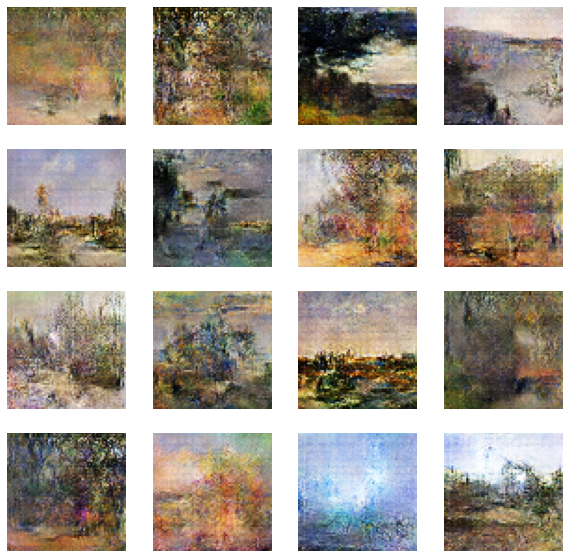

In [ ]:
# see result
noise = tf.random.normal([16,LATENT_DIM])
generated_image = generator(noise, training=False)
generated_image = generated_image / 2 + 0.5

fig = plt.figure(figsize=(10,10))
for i in range(generated_image.shape[0]):
  plt.subplot(4,4, i+1)
  plt.imshow(generated_image[i])
  plt.axis('off')
plt.show()


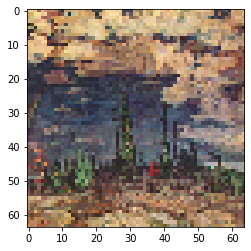

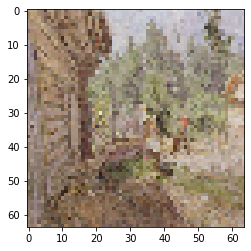

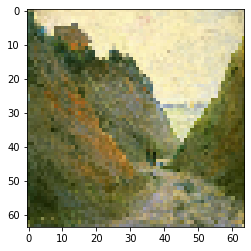

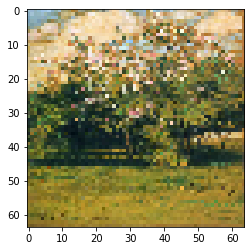

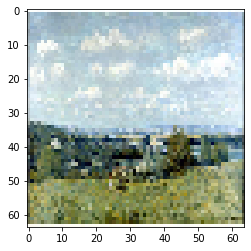

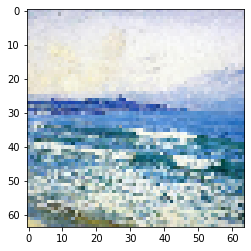

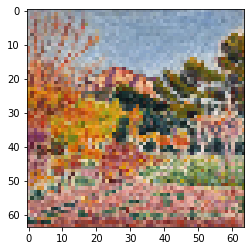

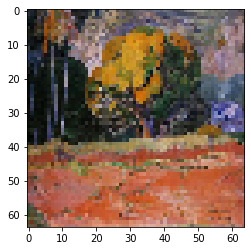

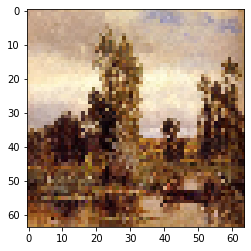

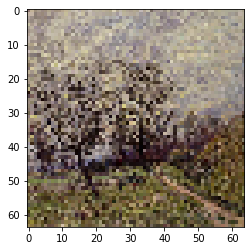

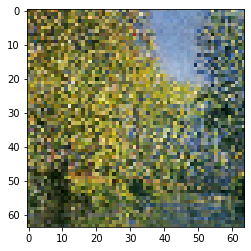

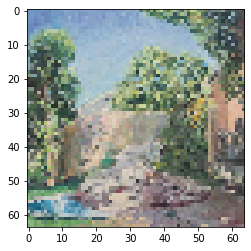

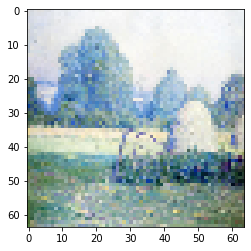

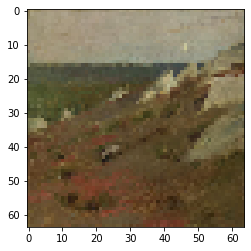

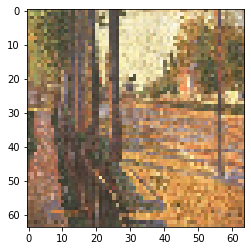

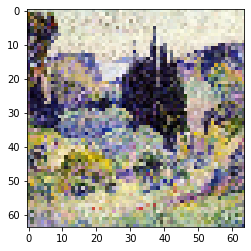

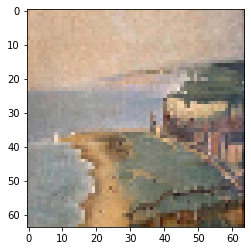

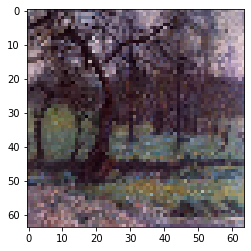

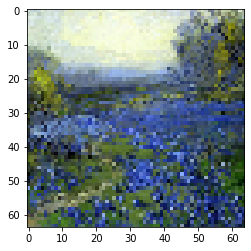

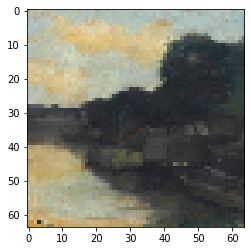

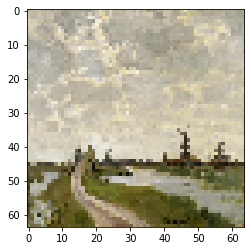

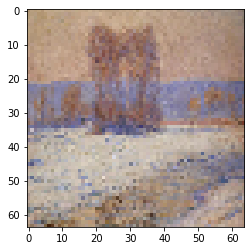

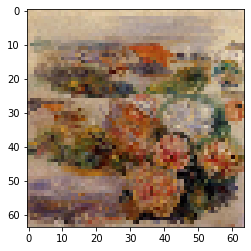

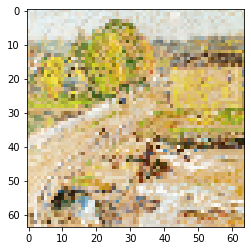

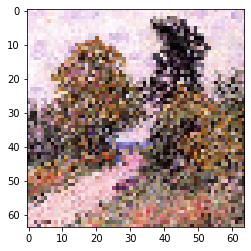

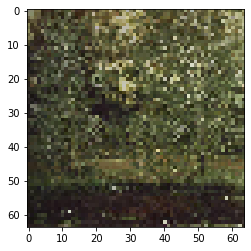

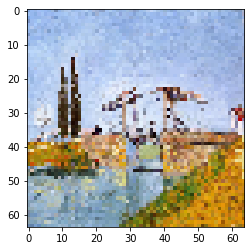

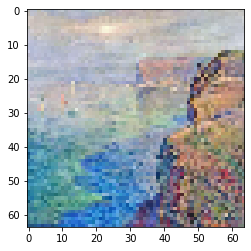

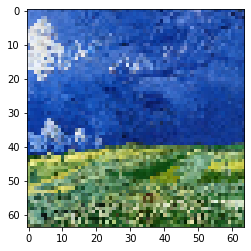

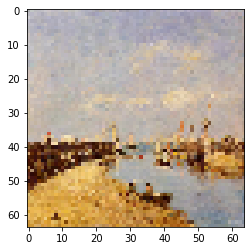

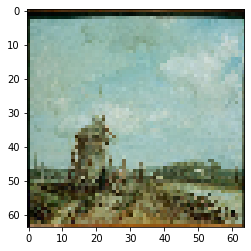

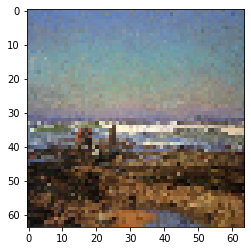

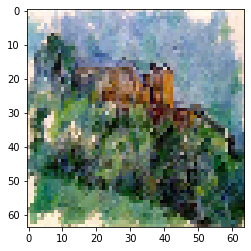

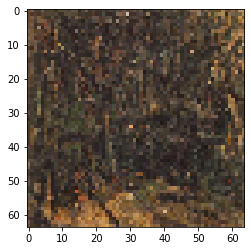

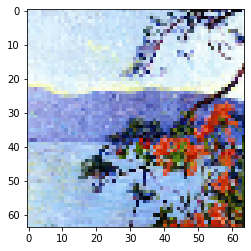

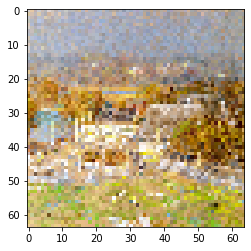

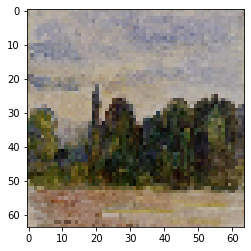

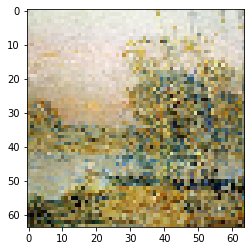

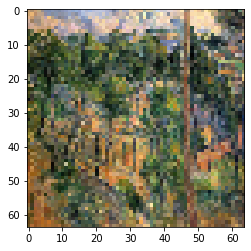

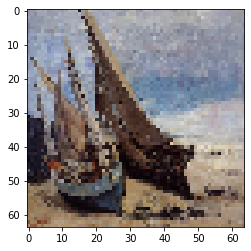

In [ ]:
# see original resized image
for batch in data_train:
  random_img = batch[0] / 2 + 0.5
  plt.imshow(random_img)
  plt.show()

In [ ]:
# helper steps

# !unrar x -r "/content/drive/MyDrive/DCGAN.rar" "/content/"

In [ ]:
save model
generator.save(model_output_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/v3_gen_2/assets


## Disclaimer & References
### Input Data taken from:
> https://www.kaggle.com/robgonsalves/impressionistlandscapespaintings <br>
### Some codes or ideas are referenced from the following pages:
> Face Generation with DCGAN: <br>
https://github.com/naokishibuya/deep-learning/blob/master/python/dcgan_celeba.ipynb

> Deep Convolutional Generative Adversarial Network:<br>
https://www.tensorflow.org/tutorials/generative/dcgan

> DCGAN v1: <br>
https://www.kaggle.com/moredeyethejedeye/dcgan-v1